In [2]:
myfile = open("pw2.txt")
txt = myfile.readlines()[0:28]
ID = txt[4][14:-2]
PSWD = txt[5][14:-2]
ID_Az = txt[17][20:-2]
PSWD_Az = txt[18][20:-2]
myfile.close()

con = pyodbc.connect('DSN=Snowflake;UID=%s;PWD=%s'% (ID, PSWD))
con.setdecoding(pyodbc.SQL_CHAR, encoding='ISO-8859-1')
cursor=con.cursor()
cursor.execute('''select a.dealer_code,
         coalesce(c.inventory_store_number, a.store_number) as store_number,
         a.doc_number, 
            a.pso_line_item_number,
            a.dealer_customer_number, 
            a.SALES_METHOD as sales_channel,
             b.orig_order_ts::date as order_date,
             a.part_number, 
            a.revised_line_qty as order_qty
        from "OEM_DMD_EXT_CURR_VW" a  
        left join "CPATT_STORAGE_PART_SALES_ORDER_VW" b
            on a.dealer_code = b.dealer_code
            and a.doc_number = b.doc_number
        left join "DDSW_DEALER_HIERARCHY_VW" c
            on a.dealer_code = c.dealer_code 
            and a.store_number = c.store_number 
            and a.part_type = c.part_type
       where a.dealer_code = 'T030'
        and a.forecast_demand_ind <> 'No'   
        and a.effective_flier <> 'Yes' 
         and b.orig_order_ts >= '2022-01-01'
         and b.orig_order_ts <= '2022-06-30'
        and a.revised_line_qty > 0;
        ''')



rows= cursor.fetchall()

part_list_1 = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [3]:
part_list_1


,DEALER_CODE,STORE_NUMBER,DOC_NUMBER,PSO_LINE_ITEM_NUMBER,DEALER_CUSTOMER_NUMBER,SALES_CHANNEL,ORDER_DATE,PART_NUMBER,ORDER_QTY
0,T030,T030-MKY,T030-5008047299,5742177768,T030-2011955-THIESS PTY LTD (LAKE VERMONT),B2B,2022-03-01,6V9746,1.00
1,T030,T030-MKY,T030-5008222112,5743747901,T030-2019084-THIESS PTY LTD (CAVAL RIDGE),B2B,2022-04-05,6V9746,4.00
2,T030,T250-NOU,T250-2000088262,5741422432,T250-2000715-NICKEL MINING COMPANY (MINIER),WO,2022-02-04,8T4223,2.00
3,T030,T030-ROK,T030-5008199421,5743550470,T030-2004763-ANGLO COAL (DAWSONS M/MENT) PTY L...,B2B,2022-03-31,2128948,1.00
4,T030,T030-TSV,T030-5007795624,5740387292,T030-2040581-LD & LJ HILLERY PTY LIMITED,OTC,2022-01-05,3769011,1.00
...,...,...,...,...,...,...,...,...,...
2114799,T030,T030-EMD,T030-5008313131,5744683811,T030-2011663-ROADTEK ASSET SERVICES WINTON,PS,2022-04-27,2306368,1.00
2114800,T030,T030-EMD,T030-8502225689,5661880347,T030-EMD,OTC,2022-01-17,2310167,1.00
2114801,T030,T030-WEI,T030-5008493392,5746356784,T030-2019364-RTA WEIPA PTY LTD,B2B,2022-06-04,2545009,2.00
2114802,T030,T030-TWB,T030-5008565911,5747061422,T030-2036142-NATIONAL PLANT AND EQUIPMENT PTY LTD,PS,2022-06-20,1450105,4.00


In [4]:



con = pyodbc.connect('DSN=Snowflake;UID=%s;PWD=%s'% (ID, PSWD))
con.setdecoding(pyodbc.SQL_CHAR, encoding='ISO-8859-1')
cursor=con.cursor()
cursor.execute(''' select ID_PART, PART_TYP_ID AS price, 
PROD_MAJ_CLS_CD AS Major, 
PROD_MNR_CLS_CD AS Minor, 
PARTS_PROD_CD AS ppc  
from "LGCYDB2_V_NACD_PART_PRC_VW"
        ''')



rows= cursor.fetchall()

part_list_2 = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [5]:
part_list_1 = part_list_1.merge(part_list_2, how= 'inner', left_on = 'PART_NUMBER', right_on = 'ID_PART').drop('ID_PART', axis = 1)

In [6]:
part_list_1

,DEALER_CODE,STORE_NUMBER,DOC_NUMBER,PSO_LINE_ITEM_NUMBER,DEALER_CUSTOMER_NUMBER,SALES_CHANNEL,ORDER_DATE,PART_NUMBER,ORDER_QTY,PRICE,MAJOR,MINOR,PPC
0,T030,T030-MKY,T030-5008047299,5742177768,T030-2011955-THIESS PTY LTD (LAKE VERMONT),B2B,2022-03-01,6V9746,1.00,AA,9,L,SSS
1,T030,T030-MKY,T030-5008222112,5743747901,T030-2019084-THIESS PTY LTD (CAVAL RIDGE),B2B,2022-04-05,6V9746,4.00,AA,9,L,SSS
2,T030,T030-MKY,T030-5008309672,5744657909,T030-2003512-EMECO INTERNATIONAL PTY LTD (EMECO),B2B,2022-04-26,6V9746,1.00,AA,9,L,SSS
3,T030,T030-MKY,T030-5008024279,5741913224,T030-2005840-BM ALLIANCE COAL OPERATIONS PTY LTD,WO,2022-02-24,6V9746,1.00,AA,9,L,SSS
4,T030,T030-MKY,T030-5008036504,5742088014,T030-2003512-EMECO INTERNATIONAL PTY LTD (EMECO),B2B,2022-02-27,6V9746,1.00,AA,9,L,SSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114376,T030,T030-ISA,T030-8502325369,5662679828,T030-ISA,OTC,2022-04-05,8T3723,1.00,AA,6,G,FCM
2114377,T030,T030-BNE,T030-5008153745,5743045284,T030-2006269-ENERFLEX SERVICES PTY LTD,OTC,2022-03-23,2461245,2.00,AA,6,Q,ADP
2114378,T030,T030-MKY,T030-5008242216,5743946362,T030-2037500-BM ALLIANCE COAL OPERATIONS PTY L...,B2B,2022-04-09,6F7223,12.00,AA,9,F,SCD
2114379,T030,T030-EMD,T030-5008293979,5744491889,T030-2016529-DA PARKER,OTC,2022-04-22,1P2772,4.00,AA,9,D,BAQ


In [35]:
trans_df = part_list_1

In [57]:
trans_df_partition = [group for name, group in trans_df.groupby(['STORE_NUMBER'])]


In [58]:

test_df = trans_df_partition[1]
original_df = trans_df_partition[1]
original_df.ORDER_QTY = original_df.ORDER_QTY.astype(float)
test_sum = sum(test_df['ORDER_QTY'].values.tolist())
print(test_sum)

2044487.0


In [59]:
test_df.ORDER_QTY = test_df.ORDER_QTY.astype(float)
original_dataframe = test_df.copy()

In [60]:
test_df

,DEALER_CODE,STORE_NUMBER,DOC_NUMBER,PSO_LINE_ITEM_NUMBER,DEALER_CUSTOMER_NUMBER,SALES_CHANNEL,ORDER_DATE,PART_NUMBER,ORDER_QTY,PRICE,MAJOR,MINOR,PPC
126,T030,T030-BNE,T030-5007827801,5740629309,T030-2036465-D & D MINING PTY LTD,PS,2022-01-13,6V9746,1.0,AA,9,L,SSS
127,T030,T030-BNE,T030-8502320273,5662631985,T030-BNE,WO,2022-03-31,6V9746,1.0,AA,9,L,SSS
128,T030,T030-BNE,T030-8502381846,5663186973,T030-BNE,OTC,2022-05-19,6V9746,1.0,AA,9,L,SSS
129,T030,T030-BNE,T030-8502304359,5662482635,T030-BNE,OTC,2022-03-18,6V9746,1.0,AA,9,L,SSS
130,T030,T030-BNE,T030-8502377439,5663160643,T030-BNE,OTC,2022-05-17,6V9746,1.0,AA,9,L,SSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114357,T030,T030-BNE,T030-5007885522,5741029222,T030-9000036-OEM Warranty and Service Letters,WO,2022-01-27,5267925,1.0,AA,9,Z,GBS
2114358,T030,T030-BNE,T030-5008601713,5747388175,T030-2019451-AVONDALE AG,OTC,2022-06-27,1028503,1.0,AA,2,E,MAM
2114359,T030,T030-BNE,T030-5007797009,5740378758,T030-2012436-EZYQUIP HIRE PTY LTD,PS,2022-01-05,2915214,1.0,AA,2,Z,SCW
2114373,T030,T030-BNE,T030-5008094040,5742605907,T030-2002205,OTC,2022-03-10,3748008,1.0,AA,9,M,GDB


In [39]:
original_dataframe

,PART_NUMBER,DEALER_CODE,STORE_NUMBER,DOC_NUMBER,PSO_LINE_ITEM_NUMBER,DEALER_CUSTOMER_NUMBER,SALES_CHANNEL,ORDER_DATE,ORDER_QTY,PRICE,MAJOR,MINOR,PPC
0,6V9746,T030,T030-BNE,T030-5007827801,5740629309,T030-2036465-D & D MINING PTY LTD,PS,2022-01-13,1.0,AA,9,L,SSS
1,6V9746,T030,T030-BNE,T030-8502320273,5662631985,T030-BNE,WO,2022-03-31,2.0,AA,9,L,SSS
2,6V9746,T030,T030-BNE,T030-8502381846,5663186973,T030-BNE,OTC,2022-05-19,1.0,AA,9,L,SSS
3,6V9746,T030,T030-BNE,T030-8502304359,5662482635,T030-BNE,OTC,2022-03-18,1.0,AA,9,L,SSS
4,6V9746,T030,T030-BNE,T030-8502377439,5663160643,T030-BNE,OTC,2022-05-17,1.0,AA,9,L,SSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201387,3L1824,T030,T030-BNE,T030-8502354769,5662933913,T030-BNE,OTC,2022-04-28,1.0,AA,5,M,010
201388,3L1824,T030,T030-BNE,T030-5008075304,5742435358,T030-2053514-SALMON EARTHMOVING HOLDINGS PTY LTD,PS,2022-03-07,1.0,AA,5,M,010
201389,3L1824,T030,T030-BNE,T030-8502260819,5662081934,T030-BNE,OTC,2022-02-14,1.0,AA,5,M,010
201390,3L1824,T030,T030-BNE,T030-8502421391,5663524658,T030-BNE,OTC,2022-06-17,1.0,AA,5,M,010


In [13]:
trdf = test_df[3000:3300]

In [14]:
mult_order = (test_df['PART_NUMBER'].value_counts()) #counts unique values
mult_order = mult_order.to_frame() #
df_filtered = mult_order[mult_order['PART_NUMBER'] >= 10] 
append_df = test_df.groupby('PART_NUMBER')['ORDER_QTY'].nunique()
df_final_multparts = pd.merge(df_filtered, append_df, left_index=True, right_index=True)
part_numbers_to_remain = df_final_multparts[df_final_multparts["ORDER_QTY"] == 1]


#greater than 10 if 90% same - make it a rolling basis depending on the percentage of the occurence

In [15]:
df_final_multparts

,PART_NUMBER,ORDER_QTY
6V8397,1435,23
1R1808,1415,20
3J1907,1303,27
6V8398,1165,25
6V9746,1037,23
...,...,...
2H2665,10,3
3537954,10,4
2292626,10,2
5P9400,10,3


In [16]:
remain_list = list(part_numbers_to_remain.index.values)

test_df = test_df.set_index("PART_NUMBER")
temp_df = test_df.loc[remain_list]
test_df.drop(remain_list,0,inplace=True)


C:\Users\gandha6\AppData\Local\Temp\ipykernel_6980\888502990.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_df.drop(remain_list,0,inplace=True)


In [17]:
temp_df = temp_df.reset_index()
temp_df

,PART_NUMBER,DEALER_CODE,STORE_NUMBER,DOC_NUMBER,PSO_LINE_ITEM_NUMBER,DEALER_CUSTOMER_NUMBER,SALES_CHANNEL,ORDER_DATE,ORDER_QTY,PRICE,MAJOR,MINOR,PPC
0,1910348,T030,T030-BNE,T030-5008460641,5751019401,T030-1000127-Project Service Call,WO,2022-05-30,1.0,AA,9,Z,GBS
1,1910348,T030,T030-BNE,T030-5008560081,5748193341,T030-1000127-Project Service Call,WO,2022-06-18,1.0,AA,9,Z,GBS
2,1910348,T030,T030-BNE,T030-5008503789,5748579002,T030-1000127-Project Service Call,WO,2022-06-07,1.0,AA,9,Z,GBS
3,1910348,T030,T030-BNE,T030-5008480105,5747704713,T030-1000127-Project Service Call,WO,2022-06-01,1.0,AA,9,Z,GBS
4,1910348,T030,T030-BNE,T030-5008136607,5743858101,T030-1000127-Project Service Call,WO,2022-03-18,1.0,AA,9,Z,GBS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10581,3L1824,T030,T030-BNE,T030-8502354769,5662933913,T030-BNE,OTC,2022-04-28,1.0,AA,5,M,010
10582,3L1824,T030,T030-BNE,T030-5008075304,5742435358,T030-2053514-SALMON EARTHMOVING HOLDINGS PTY LTD,PS,2022-03-07,1.0,AA,5,M,010
10583,3L1824,T030,T030-BNE,T030-8502260819,5662081934,T030-BNE,OTC,2022-02-14,1.0,AA,5,M,010
10584,3L1824,T030,T030-BNE,T030-8502421391,5663524658,T030-BNE,OTC,2022-06-17,1.0,AA,5,M,010


In [18]:
test_df = test_df.reset_index()

In [19]:
test_df

,PART_NUMBER,DEALER_CODE,STORE_NUMBER,DOC_NUMBER,PSO_LINE_ITEM_NUMBER,DEALER_CUSTOMER_NUMBER,SALES_CHANNEL,ORDER_DATE,ORDER_QTY,PRICE,MAJOR,MINOR,PPC
0,6V9746,T030,T030-BNE,T030-5007827801,5740629309,T030-2036465-D & D MINING PTY LTD,PS,2022-01-13,1.0,AA,9,L,SSS
1,6V9746,T030,T030-BNE,T030-8502320273,5662631985,T030-BNE,WO,2022-03-31,1.0,AA,9,L,SSS
2,6V9746,T030,T030-BNE,T030-8502381846,5663186973,T030-BNE,OTC,2022-05-19,1.0,AA,9,L,SSS
3,6V9746,T030,T030-BNE,T030-8502304359,5662482635,T030-BNE,OTC,2022-03-18,1.0,AA,9,L,SSS
4,6V9746,T030,T030-BNE,T030-8502377439,5663160643,T030-BNE,OTC,2022-05-17,1.0,AA,9,L,SSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190801,5267925,T030,T030-BNE,T030-5007885522,5741029222,T030-9000036-OEM Warranty and Service Letters,WO,2022-01-27,1.0,AA,9,Z,GBS
190802,1028503,T030,T030-BNE,T030-5008601713,5747388175,T030-2019451-AVONDALE AG,OTC,2022-06-27,1.0,AA,2,E,MAM
190803,2915214,T030,T030-BNE,T030-5007797009,5740378758,T030-2012436-EZYQUIP HIRE PTY LTD,PS,2022-01-05,1.0,AA,2,Z,SCW
190804,3748008,T030,T030-BNE,T030-5008094040,5742605907,T030-2002205,OTC,2022-03-10,1.0,AA,9,M,GDB


In [63]:


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import datetime
from datetime import date, timedelta
l = int(input("What is the percent change you would like to see in order qty?"))

#print out what the next l value should be if they want to do a percent inrease and decrease 

orig_sum = sum(test_df['ORDER_QTY'].values.tolist())


try_list = []
vals_list = []


j = 0
k_range_middle = int(1/(abs(l) * .01))
k_range_first = k_range_middle - 15
print(k_range_first)
k_range_last = k_range_middle + 15
print(k_range_last)
#lets say you want 50 percent increase
if (k_range_first) < 1:
    k_range_first = 1


if l > 0:
    for k in range (1,85):
        #includes 1 and 10
        for q in (test_df['ORDER_QTY'].values.tolist()): #q is each value in the ordre_qty
            rand_val = random.randint(0,k)
            if rand_val != 1:
                try_list.append(math.floor(q * (1 + l/100))) 
            if rand_val == 1:
                try_list.append(math.ceil(q * (1 + l/100)))
        
        vals_list.append(abs(sum(try_list) - (sum((test_df['ORDER_QTY'].values.tolist())) * (1 + l/100))))
        try_list.clear()
        
elif l < 0:
     for k in range (1,85):
        for q in (test_df['ORDER_QTY'].values.tolist()):
            rand_val = random.randint(0,k)
            if rand_val == 1:
                try_list.append(math.floor(q * (1 + l/100))) 
            if rand_val != 1:
                try_list.append(math.ceil(q * (1 + l/100)))

        vals_list.append(abs(sum(try_list) - (sum((test_df['ORDER_QTY'].values.tolist())) * (1 + l/100))))
        try_list.clear()
    
min_index = vals_list.index(min(vals_list))
print(vals_list)

k_val = min_index + 1
print(k_val)
print("moved on ")

if l > 0:
    for q in (test_df['ORDER_QTY'].values.tolist()):
        rand_val = random.randint(0,k_val)
        if rand_val == 1:
            try_list.append(math.ceil(q * (1 + l/100))) 
        if rand_val != 1:
            try_list.append(math.floor(q * (1 + l/100)))

            
    while (abs(sum(try_list) - (orig_sum * (1 + l/100))) > ((orig_sum) * 0.0025)):
        
   
        try_list.clear()
        for q in (test_df['ORDER_QTY'].values.tolist()):
            rand_val = random.randint(0,k_val)
            if rand_val == 1:
                try_list.append(math.ceil(q * (1 + l/100))) 
            if rand_val != 1:
                try_list.append(math.floor(q * (1 + l/100)))
        print(abs(sum(try_list) - orig_sum * (1 + l/100)))
        print(orig_sum * .001)
    
    
        
    test_df['ORDER_QTY'] = try_list


elif l < 0:
    for q in (test_df['ORDER_QTY'].values.tolist()):
        rand_val = random.randint(0,k)
        if rand_val == 1:
            try_list.append(math.floor(q * (1 + l/100))) 
        if rand_val != 1:
            try_list.append(math.ceil(q * (1 + l/100)))

            

    
    while (abs((sum(try_list) - (orig_sum * (1 + l/100)))) > ((orig_sum) * 0.0025)):
   
        try_list.clear()
        for q in (test_df['ORDER_QTY'].values.tolist()):
            rand_val = random.randint(0,k_val)
            if rand_val == 1:
                try_list.append(math.floor(q * (1 + l/100))) 
            if rand_val != 1:
                try_list.append(math.ceil(q * (1 + l/100)))
        print(abs(sum(try_list) - (orig_sum * (1 + l/100))))
        print(orig_sum * .001)

    test_df['ORDER_QTY'] = try_list
 




-5
25
[54589.5, 20758.5, 3779.5, 6235.5, 12592.5, 17423.5, 21214.5, 23817.5, 26251.5, 27991.5, 29510.5, 30638.5, 31695.5, 32899.5, 33609.5, 34395.5, 35103.5, 35561.5, 36026.5, 36495.5, 37015.5, 37438.5, 37744.5, 38020.5, 38212.5, 38849.5, 39007.5, 39128.5, 39279.5, 39666.5, 40017.5, 40152.5, 40274.5, 40462.5, 40547.5, 40701.5, 40902.5, 41094.5, 41119.5, 41285.5, 41430.5, 41669.5, 41595.5, 41706.5, 41810.5, 41778.5, 42003.5, 42028.5, 42149.5, 42224.5, 42322.5, 42380.5, 42545.5, 42455.5, 42569.5, 42704.5, 42737.5, 42728.5, 42807.5, 42938.5, 42887.5, 42980.5, 43047.5, 43078.5, 43123.5, 43123.5, 43239.5, 43203.5, 43304.5, 43348.5, 43371.5, 43478.5, 43484.5, 43462.5, 43498.5, 43645.5, 43593.5, 43566.5, 43580.5, 43677.5, 43693.5, 43691.5, 43809.5, 43766.5]
3
moved on 


In [21]:
test_df = test_df.append(temp_df)

C:\Users\gandha6\AppData\Local\Temp\ipykernel_6980\1593524909.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(temp_df)


In [54]:
sum(test_df["ORDER_QTY"])

2245624.0

In [55]:
sum(original_dataframe["ORDER_QTY"])

2245624.0

In [23]:
test_df = test_df.reset_index()


In [24]:
test_df["index"] = test_df["PART_NUMBER"]

In [25]:
test_df = test_df.drop("index", axis = 1)

<h2> Sensitivity Analysis </h2>

In [26]:


# define a function to calculate the sensitivity report
def sensitivity_report(before_df, after_df):
    report = {}
    for column in before_df.columns:
        before_set = set(before_df[column])
        after_set = set(after_df[column])
        added = after_set - before_set
        removed = before_set - after_set
        report[column] = {'added': added, 'removed': removed}
    return report

# calculate the sensitivity report
report = sensitivity_report(original_dataframe, test_df)

# print the report
print((report["ORDER_QTY"].values()))

#prints out the order_qty that are not in the oriignal but in the new one






dict_values([{514.0, 515.0, 1540.0, 517.0, 1030.0, 3080.0, 3081.0, 522.0, 525.0, 526.0, 528.0, 534.0, 535.0, 4119.0, 542.0, 544.0, 1056.0, 547.0, 553.0, 554.0, 556.0, 559.0, 6705.0, 561.0, 2099.0, 563.0, 564.0, 5174.0, 567.0, 1078.0, 569.0, 570.0, 1083.0, 572.0, 1595.0, 1596.0, 576.0, 585.0, 586.0, 1100.0, 1101.0, 591.0, 592.0, 1105.0, 595.0, 597.0, 598.0, 603.0, 604.0, 605.0, 606.0, 1117.0, 616.0, 1128.0, 621.0, 622.0, 2673.0, 1650.0, 2675.0, 1144.0, 636.0, 638.0, 639.0, 1152.0, 641.0, 642.0, 649.0, 1676.0, 653.0, 1677.0, 659.0, 660.0, 2200.0, 1178.0, 667.0, 671.0, 675.0, 676.0, 677.0, 1703.0, 690.0, 3250.0, 1204.0, 1716.0, 1717.0, 695.0, 698.0, 8382.0, 2750.0, 707.0, 715.0, 4811.0, 717.0, 2766.0, 718.0, 720.0, 724.0, 1760.0, 741.0, 2794.0, 748.0, 751.0, 2295.0, 763.0, 770.0, 774.0, 778.0, 779.0, 1298.0, 787.0, 1309.0, 798.0, 289.0, 804.0, 808.0, 809.0, 1320.0, 2349.0, 308.0, 309.0, 825.0, 827.0, 316.0, 317.0, 829.0, 321.0, 322.0, 833.0, 324.0, 2882.0, 838.0, 335.0, 337.0, 349.0, 862.

         ORDER_QTY
126            1.0
127            1.0
128            1.0
129            1.0
130            1.0
...            ...
2114357        1.0
2114358        1.0
2114359        1.0
2114373        1.0
2114377        2.0

[201392 rows x 1 columns]
         ORDER_QTY
126              2
127              1
128              1
129              2
130              1
...            ...
2114357          1
2114358          1
2114359          1
2114373          1
2114377          3

[201392 rows x 1 columns]


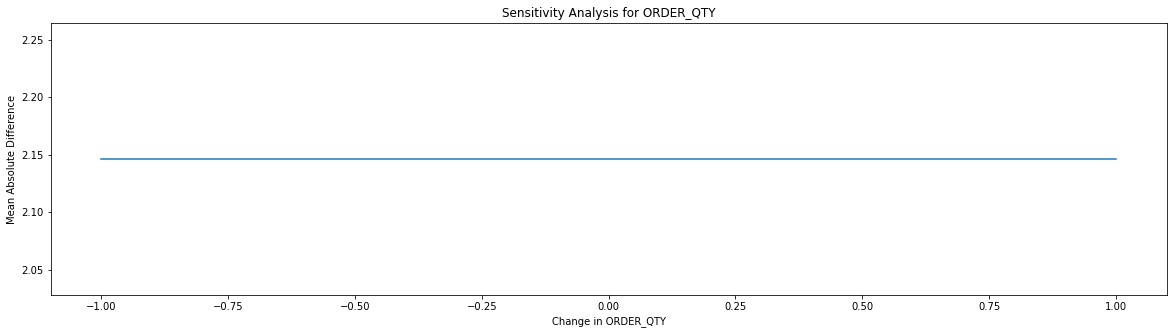

In [64]:
import numpy as np
import matplotlib.pyplot as plt

first = original_dataframe.select_dtypes(include=['number'])
second = test_df.select_dtypes(include=['number'])

print(first)
print(second)

def metric(df1, df2, column):

    return(np.mean(np.abs(df1[column] - df2[column])))

# perform the sensitivity analysis for a range of values and for each column
sensitivity_values = np.linspace(-1, 1, 21)
metrics = {}
for column in first.columns:
    column_metrics = []
    for value in sensitivity_values:
        modified_df2 = second.copy()

        metric_value = metric(first, second, column)
        column_metrics.append(metric_value)
    metrics[column] = column_metrics

# plot the results of the sensitivity analysis for each column
fig, ax = plt.subplots(ncols=len(first.columns), figsize=(20, 5))
for i, column in enumerate(first.columns):
    ax.plot(sensitivity_values, metrics[column])
    ax.set_xlabel('Change in {}'.format(column))
    ax.set_ylabel('Mean Absolute Difference')
    ax.set_title('Sensitivity Analysis for {}'.format(column))
plt.show()


<AxesSubplot:title={'center':'Major and Order Qty'}, ylabel='MAJOR'>

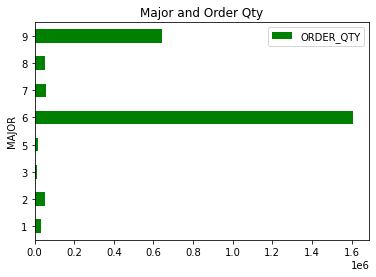

In [65]:
(test_df.groupby(["MAJOR"]).agg("sum").reset_index()).plot.barh(x='MAJOR', y='ORDER_QTY',
             title='Major and Order Qty', color='green')

In [66]:



def magnitude_difference(old_df, new_df):
    # filter out non-numeric columns
    numeric_cols = old_df.select_dtypes(include=['number']).columns
    
    # compute the difference in magnitude between the old and new dataframes
    diff_df = pd.DataFrame(index=numeric_cols, columns=['max_diff', 'mean_diff', 'std_diff'])
    for col in numeric_cols:
        old_col = old_df[col]
        new_col = new_df[col]
        max_diff = (new_col - old_col).abs().max()
        mean_diff = (new_col - old_col).abs().mean()
        std_diff = (new_col - old_col).abs().std()
        diff_df.loc[col] = [max_diff, mean_diff, std_diff]

    return diff_df

magnitude_difference(original_dataframe, test_df)


,max_diff,mean_diff,std_diff
ORDER_QTY,2421.0,2.146242,14.21539


In [67]:



def paq_change(old_df, new_df):
    # filter out non-numeric columns
    
    # compute the difference in magnitude between the old and new dataframes

    final_df = pd.DataFrame()
    
    final_df["Magnitude Change"] = abs((new_df["ORDER_QTY"] - old_df["ORDER_QTY"])).sort_values()
    #can choose which one you want to sort
    final_df["Percent Change"] = abs(((new_df["ORDER_QTY"] - old_df["ORDER_QTY"]) / old_df["ORDER_QTY"]))
    final_df["PART_NUMBER"] = old_df["PART_NUMBER"] 

    return final_df

paq_change(original_dataframe, test_df)


,Magnitude Change,Percent Change,PART_NUMBER
1866191,0.0,0.000000,1974859
1025478,0.0,0.000000,3635819
1025477,0.0,0.000000,3635819
1774170,0.0,0.000000,3D4603
1025464,0.0,0.000000,3635819
...,...,...,...
722004,989.0,0.210247,5417162
962917,1279.0,0.209810,5417088
701355,1464.0,0.209832,4568467
829155,1601.0,0.210105,4568434


In [68]:
temp_df = test_df.groupby(['MAJOR'])['ORDER_QTY'].agg('sum')
orig_Df = original_dataframe.groupby(['MAJOR'])['ORDER_QTY'].agg('sum')
testerz_df = (((temp_df - orig_Df)/orig_Df)*100)
testerz_df = testerz_df.to_frame()
testerz_df





,ORDER_QTY
MAJOR,
1,20.222222
2,23.206016
3,18.444056
5,23.006555
6,21.037465
7,29.591903
8,23.518794
9,20.373166
